# RM-MMDnet

In [1]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
from ops import *
from utils import *
import os
import time
from glob import glob
from scipy.misc import imsave as ims
from random import randint
from data_providers import *
slim = tf.contrib.slim
import scipy as sp
import pickle
from tensorflow.keras import datasets
import tensorflow.data as td
from tqdm import tqdm_notebook as tqdm

config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.3),
    device_count = {'GPU': 1}
)

Populating the interactive namespace from numpy and matplotlib


In [2]:
params = {
    'batch_size':64,
    'image_dim':32*32*3,
    'imageshape': [64,32,32,3],
    'c':3,
    'h':32,
    'w':32,
    'epochs' :20,
    'noise_dim':128
}

In [3]:
'''Keras function to download CIFAR10'''
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = np.float32(train_images / 255.0), np.float32(test_images / 255.0)


In [4]:
'''Notice that unlike usual GAN, this is not a binary classifier. The output is a vector of dim 3.'''
def discriminator(z, z_dim=params['noise_dim'], reuse=False, training=True):
    
    with tf.variable_scope("disc") as scope:
        if reuse:
                scope.reuse_variables()
      
        h0 = z
        h1 = lrelu(slim.fully_connected(h0, int(z_dim/2))) 
        h1 = slim.dropout(h1, keep_prob=0.5, is_training=training)
        h2 = lrelu(slim.fully_connected(h1, int(z_dim/4)))
        h2 = slim.dropout(h2, keep_prob=0.5, is_training=training)
        h3 = slim.fully_connected(h2, 3)

        return h3
    
    
def encoder(image, z_dim=params['noise_dim'], batchsize=params['batch_size'], h=params['h'], w=params['w'], c=params['c'], df_dim=params['h']):
    with tf.variable_scope("encoder") as scope:
      
        h0 = image
        h0 = lrelu(conv2d(h0, 3, df_dim, name='d_h0_conv')) #16x16x32
        h1 = lrelu(tf.contrib.layers.batch_norm(conv2d(h0, df_dim, df_dim*2, name='d_h1_conv'))) #8x8x64
        h2 = lrelu(tf.contrib.layers.batch_norm(conv2d(h1, df_dim*2, df_dim*2*2, name='d_h2_conv'))) #4x4x128
        h3 = tf.reshape(h2, [batchsize, -1])
        mu = dense(h3, 4*4*df_dim*4, z_dim, scope='d_h4_lin_mu') #2048
        log_sigma_sq = dense(h3, 4*4*df_dim*4, z_dim, scope='d_h4_lin_sigma') #2048

        return mu,log_sigma_sq
    

        
def generator(z,z_dim=params['noise_dim'],batchsize=params['batch_size'],h=params['h'],w=params['w'],c=params['c'],gf_dim=params['h'],reuse=False):
    with tf.variable_scope("gen") as scope:
        if reuse:
                scope.reuse_variables()
        z2 = dense(z, z_dim, 4*4*gf_dim*4, scope='g_h0_lin')
        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.reshape(z2, [-1, 4, 4, gf_dim*4]))) # 4x4x128
        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv_transpose(h0, [batchsize, 8, 8, gf_dim*2], "g_h1"))) #8x8x64
        h2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv_transpose(h1, [batchsize, 16, 16, gf_dim*1], "g_h2"))) #16x16x32
        h3 = tf.nn.sigmoid(conv_transpose(h2, [batchsize, h, w, c], "g_h4"))

        return h3  
    
    

        

In [18]:
tf.reset_default_graph()

# DataLoader and iterator
batch = td.Dataset.from_tensor_slices(train_images).shuffle(len(train_images), reshuffle_each_iteration=True).repeat().batch(params['batch_size'], drop_remainder=True).prefetch(10)
print('Dataset Object:', batch)
iterator = batch.make_initializable_iterator()
batch_images = iterator.get_next()
print('Iterator:' ,batch_images)


# Placeholders for input 
gen_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='input_noise')
m_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='m_input')
n_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='n_input')


# Build VAE Network
mu,log_sigma_sq = encoder(batch_images)
eps = tf.random_normal((params['batch_size'], params['noise_dim']), 0, 1, dtype=tf.float32)
z = mu+(tf.sqrt(tf.exp(log_sigma_sq))* eps)
gen_sample = generator(z)
# Random Sampler
gen_rv = generator(gen_input,reuse=True)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(eps)
disc_fake = discriminator(z,reuse=True)
disc_m = discriminator(eps+m_input,reuse=True)
disc_m_gen = discriminator(z+n_input,reuse=True)

# Build Loss



a = np.tile([1.,0.,0.],params['batch_size'])
b = np.tile([0.,1.,0.],params['batch_size'])
c = np.tile([0.,0.,1.],params['batch_size'])
label_a = tf.reshape(a,[params['batch_size'],3])
label_b = tf.reshape(b,[params['batch_size'],3])
label_c = tf.reshape(c,[params['batch_size'],3])

disc_loss_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_real, labels=label_a))
disc_loss_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_fake, labels=label_b))
disc_loss_3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m, labels=label_c))
disc_loss_4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m_gen, labels=label_c))
dloss = disc_loss_1 + disc_loss_2 + disc_loss_3 + disc_loss_4

r_p_m = (tf.nn.softmax(disc_m_gen)[:,0])/(tf.nn.softmax(disc_m_gen)[:,2])
r_q_m = (tf.nn.softmax(disc_m_gen)[:,1])/(tf.nn.softmax(disc_m_gen)[:,2])

sbd = tf.square(r_p_m - 1) - tf.square(r_q_m - 1) - 2*(r_q_m-1)*(r_p_m-r_q_m)
sbd_loss = tf.reduce_mean(sbd)
kld = -0.5 * tf.reduce_sum(1 + log_sigma_sq - tf.square(mu) - tf.exp(log_sigma_sq), 1)
BCE = -tf.reduce_sum(tf.reshape(batch_images, [params['batch_size'], -1]) * tf.log(1e-10 + tf.reshape(gen_sample, [params['batch_size'], -1]))
                           + (1-tf.reshape(batch_images, [params['batch_size'], -1])) * tf.log(1e-10 + 1 - tf.reshape(gen_sample, [params['batch_size'], -1])),1)
vaeloss = tf.reduce_mean(sbd + BCE)
      
#Build Optimizers
t_vars = tf.trainable_variables()
e_vars = [var for var in t_vars if 'encoder' in var.name]
g_vars = [var for var in t_vars if 'gen' in var.name]
d_vars = [var for var in t_vars if 'disc' in var.name]

learningrate_gen = 1e-4
learningrate = 1e-4
beta1 = 0.5
g_optim = tf.train.AdamOptimizer(learningrate_gen, beta1=beta1).minimize(vaeloss, var_list=g_vars+e_vars)
d_optim = tf.train.AdamOptimizer(learningrate,     beta1=beta1).minimize(dloss, var_list=d_vars)

#Initialize
start_time = time.time()
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(iterator.initializer)

Dataset Object: <DatasetV1Adapter shapes: (64, 32, 32, 3), types: tf.float32>
Iterator: Tensor("IteratorGetNext:0", shape=(64, 32, 32, 3), dtype=float32)



Epoch: [ 0] [ 780/ 781] time: 54.5227, dloss: 3.3810, gloss: 1897.9802,SBD: 0.7456


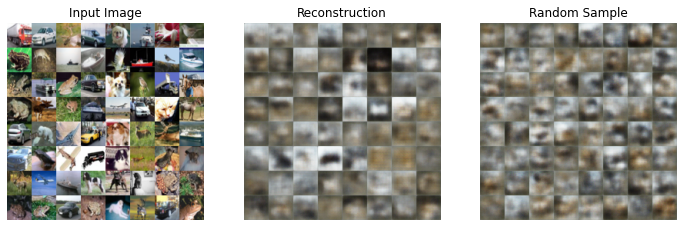


Epoch: [ 1] [ 780/ 781] time: 101.4529, dloss: 2.9588, gloss: 1942.0012,SBD: 0.8062


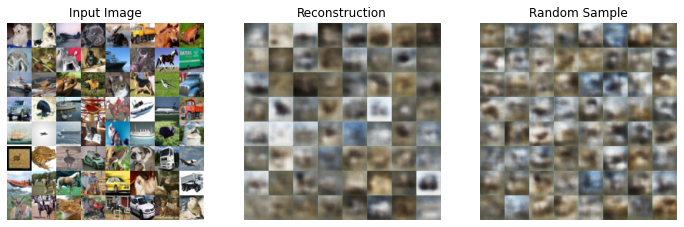


Epoch: [ 2] [ 780/ 781] time: 148.3089, dloss: 3.0518, gloss: 1912.5730,SBD: 0.7569


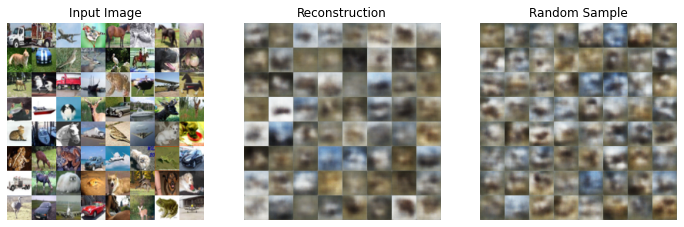


Epoch: [ 3] [ 780/ 781] time: 195.1485, dloss: 2.9527, gloss: 1938.9119,SBD: 0.8885


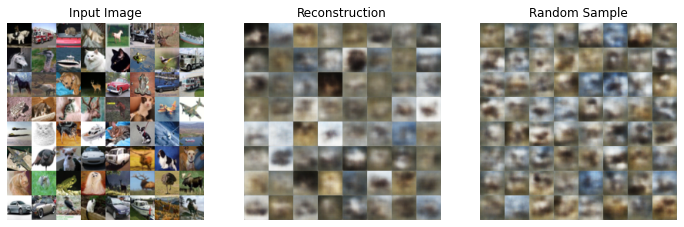


Epoch: [ 4] [ 780/ 781] time: 242.1277, dloss: 3.0616, gloss: 1905.9213,SBD: 0.9123


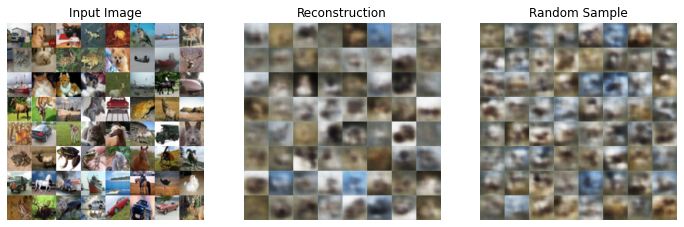


Epoch: [ 5] [ 780/ 781] time: 288.9701, dloss: 2.8157, gloss: 1892.8127,SBD: 0.9210


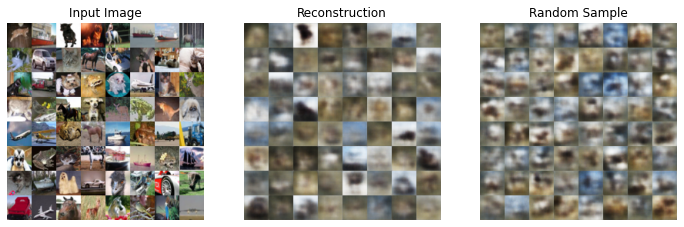


Epoch: [ 6] [ 780/ 781] time: 335.8568, dloss: 2.8219, gloss: 1848.8932,SBD: 0.8922


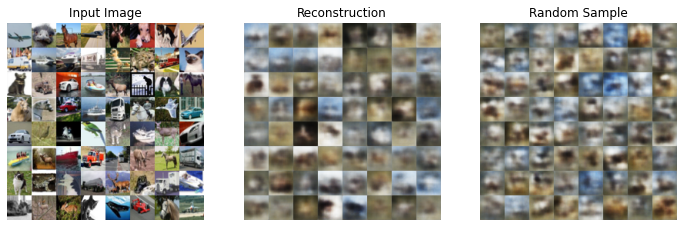


Epoch: [ 7] [ 780/ 781] time: 382.8583, dloss: 2.8473, gloss: 1889.0505,SBD: 0.9663


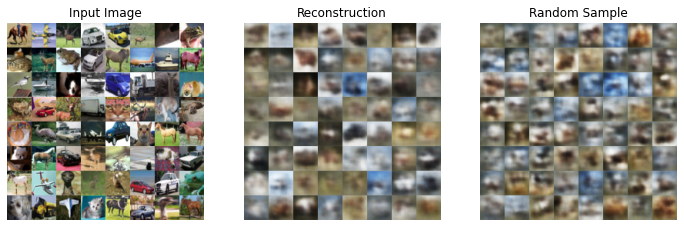

In [ ]:
# '------Training VAE and SBD Networks--------------------'
batch_z = np.random.uniform(-1, 1, [params['batch_size'], params['noise_dim']]).astype(np.float32) 
num_batches = int(len(train_images)/params['batch_size'])
dl,gl,sl=0,0,0
for epoch in tqdm(xrange(params['epochs'])):
    for idx in tqdm(range(num_batches)):
        
        m = np.random.normal(0, .01, size=[params['batch_size'], params['noise_dim']])
        n_ = np.random.normal(0, .01, size=[params['batch_size'], params['noise_dim']])

        # Train
        feed_dict = {m_input: m, n_input: n_}
        for _ in range(4):
            sess.run([d_optim],feed_dict=feed_dict)
        _, _, gl, dl, sl = sess.run([d_optim, g_optim, vaeloss, dloss, sbd_loss],
                                feed_dict=feed_dict)
        
        
#     '---------Printing intermediate results-------------'      
    if epoch % 1 == 0:
        
        print("Epoch: [%2d] [%4d/%4d] time: %4.4f, dloss: %4.4f, gloss: %4.4f,SBD: %4.4f" % (epoch, idx, num_batches, time.time() - start_time, dl,gl,sl))
        
        images = sess.run([batch_images,gen_sample,gen_rv],feed_dict = {gen_input: batch_z})
        fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,12))
        t = ['Input Image', 'Reconstruction', 'Random Sample']
        for i,image in enumerate(images):
            sdata = np.expand_dims(image,0)
            img = merge(sdata[0],[8,8])
            ax[i].imshow(img)
            ax[i].set_title(t[i])
            ax[i].axis('off')
        plt.show()
    




In [ ]:
'''Generate random samples and save to compute FID later.'''
gen_images = np.vstack([sess.run(gen_sample,feed_dict={ \
            gen_input: np.random.uniform(-1, 1, [batchsize, z_dim]).astype(np.float32) }) for _ in range(250)])

print(gen_images.shape)
np.save("cifar_breg",gen_images)